<a href="https://colab.research.google.com/github/Reznic/SVM-Project/blob/main/maman13_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maman 13
====================
Tal Reznik
318252095




# 4 
## Part A
**Implementation of SVM, using SMO algorithm**

In [184]:
import numpy as np
from functools import lru_cache
from time import time


class SVM:
    """Support Vector Machine model, implemented using the SMO algorithm."""

    def __init__(self, c, kernel=None, accuracy=0.001):
        self.c = c
        self.epsilon = accuracy
        if kernel is None:
            self.K = lambda X, Y: X.dot(Y)
        else:
            self.K = kernel
        
        self.dim = None
        self.alpha = None
        self.X = None
        self.Y = None
        self.N = None
        self.b = None

    def predict(self, x):
        """Predict the label of given feature vectors - x.

        The model must first be trained (see SVM.fit).
        """
        return np.sign(self._f(x))

    def evaluate_model(self, data, labels):
        """Predict samples in the given dataset, and return the 
        misclasification ratio.
        """
        predicted_labels = self.predict(data)
        # count misclassified labels
        error_count = sum(abs(predicted_labels - labels) / 2)
        error_ratio = error_count / len(labels)
        return error_ratio
        
    def fit(self, X, Y):
        """Train the SVM model, on a list of example vectors and their labels.

        X - Matrix of feature vector examples to train on.
        Y - corresponding labels of the training examples.
        """
        if len(X) != len(Y):
            raise ValueError(f"Mismatching data size of X and Y: "
                             f"{len(X)} and {len(Y)}")
        self.X = X
        self.Y = Y
        self.N = len(self.X)
        self.dim = len(self.X[0])

        # Initialize model state
        self.alpha = np.zeros(self.N)
        self.b = 0
        self.alpha_update_ts = time()

        alpha_changed = False
        examine_all = True

        while(alpha_changed or examine_all):
            alpha_changed = False
            if examine_all:
                for i in range(self.N):
                    alpha_changed = self._smo_examine_example(i)
            else:
                for i in range(self.N):
                    if self.alpha[i] > 0 and self.alpha[i] < self.c:
                        alpha_changed = self._smo_examine_example(i)

            if examine_all == True:
                examine_all = False
            elif not alpha_changed:
                examine_all = True

    def _f(self, x):
        if self.alpha is None or self.b is None:
            raise ValueError("SVM model Not trained.")
        b = self.b
        a = self.alpha
        y = self.Y
        X = self.X
        K = self.K
        # W*X + b
        return (y*a).T.dot(K(X, x.T)) + b

    def _smo_examine_example(self, i2):
        # Todo: use heuristics
        for i1 in range(self.N):
            if i1 != i2:
                if self._smo_step(i1, i2):
                    return True
        return False

    def _obj_func(self, i2, alpha2):
        result = 0
        a = np.copy(self.alpha)
        a[i2] = alpha2
        for i in range(self.N):
            for j in range(self.N):
                result += a[i]*a[j]*self.Y[i]*self.Y[j]*self.K(self.X[i], self.X[j])

    @lru_cache(maxsize=256)
    def _get_error(self, i, alpha_update_ts, b):
        return self.Y[i] - self._f(self.X[i])

    def _smo_step(self, i1, i2):
        if i1 == i2:
            return False

        a = self.alpha
        Y = self.Y
        X = self.X
        K = self.K
        eps = self.epsilon

        # Calculate constraints bounds on alpha-2
        if Y[i1] * Y[i2] == 1:
            L = max(0, a[i2] + a[i1] - self.c)
            H = min(self.c, a[i2] + a[i1])
        else:
            L = max(0, a[i2] - a[i1])
            H = min(self.c, self.c + a[i2] - a[i1])
            
        if L == H:
            return False

        # Calculate the optimal alpha-2, and clip it to fit the bounds
        K11 = K(X[i1], X[i1])
        K22 = K(X[i2], X[i2])
        K12 = K(X[i1], X[i2])
        # E1 = Y[i1] - self._f(X[i1])
        # E2 = Y[i2] - self._f(X[i2])
        E1 = self._get_error(i1, self.alpha_update_ts, self.b)
        E2 = self._get_error(i2, self.alpha_update_ts, self.b)
        eta = K11 + K22 - 2*K12

        if eta > 0:
            optimal_a2 = a[i2] + Y[i2] * (E2 - E1) / eta
            a2_clip = max(min(optimal_a2, H), L)
        else:
            Lobj = self._obj_func(i2, L)
            Hobj = self._obj_func(i2, H)
            if (Lobj < Hobj - eps):
                a2_clip = L
            elif (Lobj > Hobj + eps):
                a2_clip = H
            else:
                a2_clip = a[i2]

        # Check stop condition - insignificant alpha change
        delta_a2 = a[i2] - a2_clip
        if abs(delta_a2) < eps * (a[i2] + a2_clip + eps):
            return False

        # Update alpha-1 and alpha-2
        a[i1] =  a[i1] + Y[i1] * Y[i2] * delta_a2
        a[i2] = a2_clip
        self.alpha_update_ts = time()

        # Find a non-bounded example
        s=0
        for i in range(self.N):
            if a[i] > 0 and a[i] < self.c:
                s = i

        # Update the bias
        self.b = Y[s] - (a * Y).dot(K(X, X[s]))
        return True

    def get_hyperplane(self):
        W = (self.alpha * self.Y).dot(self.X)
        return W, self.b


In [185]:
import matplotlib.pyplot as plt

# Plotting utility functions
def plot_data(X, Y):
    positive_samples = np.array([X[i] for i, y in enumerate(Y) if y >= 1])
    negative_samples = np.array([X[i] for i, y in enumerate(Y) if y < 0])
    if positive_samples.size > 0:
        plt.scatter(x=positive_samples[:,0], y=positive_samples[:,1], color="b", s=1)
    if negative_samples.size > 0:
        plt.scatter(x=negative_samples[:,0], y=negative_samples[:,1], color="r", s=1)
    plt.axes().set_aspect('equal')

def plot_line(w, b, label, color):
    x = np.linspace(*data_bounds,50)
    y = (b + w[0] * x) / -w[1]
    plt.plot(x, y, color, label=label)
    plt.legend(loc='upper left')

In [186]:
from random import randint
dim = 2
data_bounds = (-100, 100)
N = 30  # Data samples size

# Generate random target hyperplane line
f = np.random.uniform(low=data_bounds[0], high=data_bounds[1], size=(3))
# f = np.array([1.5, 0])

# Generate random Data samples
X_train = np.random.uniform(low=data_bounds[0], high=data_bounds[1], 
                            size=(N, dim))
# X_train = np.array([[1, 2], [2,1]])
# Y_train = np.array([1, -1])

def generate_labels(X, f):
    """Generate data labels - on which side of the line every sample is, 
    by calculating the sign of the dot product between normal of target line
    and the vector from a point on the line, to the sample.
    """
    f_normal = f[1:]
    # Find intersection of f with y axis
    point_on_line = np.array([0, f[0] / -f[2]])
    labels = np.sign((X - point_on_line).dot(f_normal))
    return labels

Y_train = generate_labels(X_train, f)
# Y_train[1] = -Y_train[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


0.0


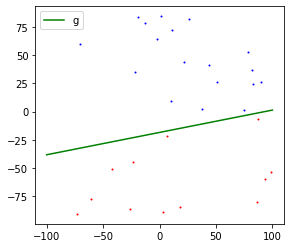

In [187]:
# Plotting
plot_data(X_train, Y_train)
# plot_line(f[1:], f[0], "f", "black")

# Training
svm = SVM(c=100)
svm.fit(X_train, Y_train)
W, b = svm.get_hyperplane()
plot_line(W, b, "g", "green")
err = svm.evaluate_model(X_train, Y_train)
print(err)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


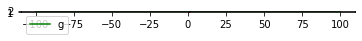

In [188]:
X_train2 = np.array([[1, 2], [1,1]])
Y_train2 = np.array([1, -1])
# Plotting
plot_data(X_train2, Y_train2)

# Training
svm2 = SVM(c=100)
svm2.fit(X_train2, Y_train2)
W, b = svm2.get_hyperplane()
plot_line(W, b, "g", "green")

print(svm2.evaluate_model(X_train2, Y_train2))

# Part B
## (a) 
**Scatter plot of the Iris dataset**

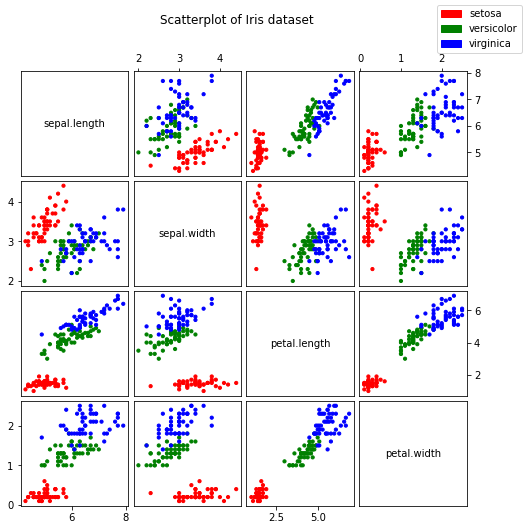

In [189]:
from sklearn import datasets
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def scatterplot_matrix(data, names, **kwargs):
    """Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
    against other rows, resulting in a nrows by nrows grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Returns the matplotlib figure
    object containg the subplot grid."""
    numvars, numdata = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8,8))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            axes[x,y].scatter(data[y], data[x], **kwargs)

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

    return fig


iris = datasets.load_iris()
iris_data = iris["data"]
iris_lables= iris["target"]
color_to_lable = {0:"red", 1:"green", 2:"blue"}
colors = [color_to_lable[i] for i in iris_lables]

fig = scatterplot_matrix(iris_data.T, ['sepal.length', 'sepal.width', \
                                       'petal.length', 'petal.width'],
                         c=colors, s=10)
fig.suptitle('Scatterplot of Iris dataset')

patches = [mpatches.Patch(color=color_to_lable[i], 
                          label=iris["target_names"][i]) for i in [0,1,2]]
fig.legend(handles=patches, loc="upper right")
plt.show()

The "Iris setosa" species seems to be the most separable.

## (b)

**Splitting the Iris dataset**

In [190]:
from sklearn.model_selection import train_test_split

def split_dataset(data, labels, train_size, test_size, validation_size):
    second_split_size = validation_size / (test_size + validation_size)
    X_train, X_nontrain, Y_train, Y_nontrain = \
        train_test_split(iris_data, iris_lables, train_size=train_size,
                         random_state=42)
    X_test, X_val, Y_test, Y_val = \
        train_test_split(X_nontrain, Y_nontrain, test_size=second_split_size,
                         random_state=42)
    return (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)


train_set, test_set, validation_set = split_dataset(iris_data, iris_lables, 
                                                    train_size=0.6, 
                                                    test_size=0.2, 
                                                    validation_size=0.2)

train_X, train_Y = train_set
test_X, test_Y = test_set
validation_X, validation_Y = validation_set

**Multiclass SVM**

In [191]:
class OneVsAllSVM(SVM):
    """An SVM model that classifies one label class (unique_label), 
    from other label classes.
    Instances from the unique class, are labeld: 1, 
    and instances from other classes are labeled: -1
    """
    def __init__(self, unique_label, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.unique_label = unique_label

    def get_binary_labels(self, labels):
        """Generate new labels vector, by replacing the unique label with 1,
        and other labels with -1.
        """
        return [1 if label == self.unique_label else -1 
                for label in labels]

    def fit(self, X, Y):
        binary_labels = self.get_binary_labels(Y)
        super().fit(X, binary_labels)

    def evaluate_model(self, data, labels):
        binary_labels = self.get_binary_labels(labels)
        return super().evaluate_model(data, binary_labels)

    def get_table_of_confustion(self, data, labels):
        confusion_table = np.zeros((2, 2))
        predictions = self.predict(data)
        for i in range(len(labels)):
            if predictions[i] == 1:
                predict_index = 0
            else:
                predict_index = 1
            if labels[i] == self.unique_label:
                actual_index = 0
            else:
                actual_index = 1
            confusion_table[actual_index][predict_index] += 1
        return confusion_table
    
    def get_sensitivity(self, data, labels):
        predictions = self.predict(data)
        true_positive = len([1 for i in range(len(labels)) 
                            if labels[i] == self.unique_label and 
                             predictions[i] == 1])
        false_negative = len([1 for i in range(len(labels))
                            if labels[i] == self.unique_label and 
                             predictions[i] == -1])
        return true_positive / (true_positive + false_negative)


class MulticlassSVM:
    """ """

    def __init__(self, class_labels, c, kernel=None, accuracy=0.001):
        self.class_labels = class_labels

        # Support option of giving same hyperparam for all SVM classifiers
        if type(c) is not list:
            c = [c] * len(class_labels)
        if type(kernel) is not list:
            kernel = [kernel] * len(class_labels)
        if type(accuracy) is not list:
            accuracy = [accuracy] * len(class_labels)

        # Init One-VS-All SVM model for each class
        self.classifiers = [OneVsAllSVM(label, c[i], kernel[i], accuracy[i]) 
                            for i, label in enumerate(class_labels)]

    def predict(self, x):
        """Predict the label of given feature vectors - x.

        The model must first be trained (see SVM.fit).
        """
        # Generate predictions of x, from every One-VS-All classifier
        predictions = [classifier._f(x) for classifier in self.classifiers]
        # Get the index of the classifier returning the maximal number -
        # The most "confident" classification, and return it's unique label.
        max_classifiers = np.argmax(np.array(predictions), axis=0)
        return [self.classifiers[i].unique_label for i in max_classifiers]
        
    def fit(self, X, Y):
        """Train the SVM model, on a list of example vectors and their labels.

        X - Matrix of feature vector examples to train on.
        Y - corresponding labels of the training examples.
        """
        for classifier in self.classifiers:
            classifier.fit(X, Y)

    def evaluate_model(self, data, labels):
        """Predict samples in the given dataset, and return the 
        misclasification ratio.
        """
        predicted_labels = self.predict(data)
        # count misclassified labels
        error_count = sum(abs(predicted_labels - labels) / 2)
        error_ratio = error_count / len(labels)
        return error_ratio

    def get_confusion_matrix(self, data, labels):
        confusion_matrix = np.zeros((len(self.class_labels), 
                                     len(self.class_labels)))
        predicted_labels = self.predict(data)
        for i in range(len(labels)):
            confusion_matrix[predicted_labels[i]][labels[i]] += 1

        return confusion_matrix

### Train and evaluate 3 SVM classifiers, for each iris species, with different C values

In [192]:
"""
 Train and evaluate 3 SVM classifiers, for each iris species, with different C values.
"""

def optimize_c(kernel):

    classes = np.unique(iris["target"])

    for C in [100, 10, 5, 2, 1, 0.9, 0.8, 0.5, 0.2, 0.1]:
        print(f"C={C}")
        iris_model = MulticlassSVM(class_labels=classes, c=C, kernel=kernel)
        iris_model.fit(train_X, train_Y)
        for classifier in iris_model.classifiers:
            class_name = iris['target_names'][classifier.unique_label]
            err = classifier.evaluate_model(validation_X, validation_Y)
            print(f"{class_name} classification error: {err}")

# optimize_c(kernel=None)

### C hyperparameter tuning, by validation set error comparison
| C   | Setosa validation Error | Virginica validation Error | Versic validation Error |
|-----|-------------------------|----------------------------|-------------------------|
| 10  | 0                       | 0                          | 0.3                     |
| 5   | 0                       | 0.03333333333333333        | 0.3333333333333333      |
| 1   | 0                       | 0                          | 0.3333333333333333      |
| 0.9 | 0                       | 0                          | 0.3                     |
| 0.8 | 0                       | 0                          | 0.3                     |
| 0.5 | 0                       | 0                          | 0.3333333333333333      |
| 0.2 | 0                       | 0                          | 0.4333333333333333      |
| 0.1 | 0                       | 0                          | 0.4333333333333333      |

Conclusion: **C=0.9** yields the best validation-set error,
for all the 3 classifiers

### (c)
**Confusion Matrix**

Model accuracy on test set is: 0.9833333333333333


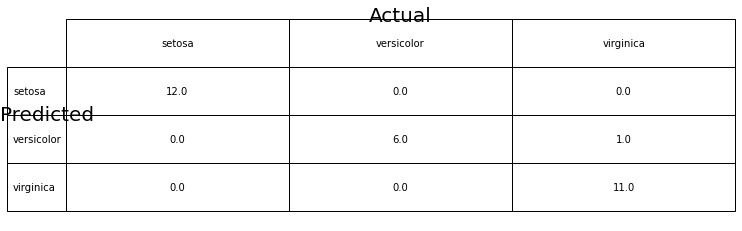

In [193]:
classes = np.unique(iris["target"])
iris_model = MulticlassSVM(class_labels=classes, c=1)
iris_model.fit(train_X, train_Y)
accuracy = 1 - iris_model.evaluate_model(test_X, test_Y)
print(f"Model accuracy on test set is: {accuracy}")
confusion_matrix = iris_model.get_confusion_matrix(test_X, test_Y)

# Plotting the table
table = plt.table(cellText=confusion_matrix, loc=(0,0), cellLoc='center', 
          rowLabels=iris['target_names'], colLabels=iris['target_names'])
table.scale(2, 4)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
plt.annotate('Actual', (.5,1), ha="center", va="top", fontsize=20)
plt.annotate('Predicted', (0,0.5), ha="left", va="center", fontsize=20, xycoords="figure fraction")
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)

Results:
Our model had only one misclassification out of 30 test-set samples
misclassified a virginica as a versicolor species.


# (d)
**Tables of confusion**

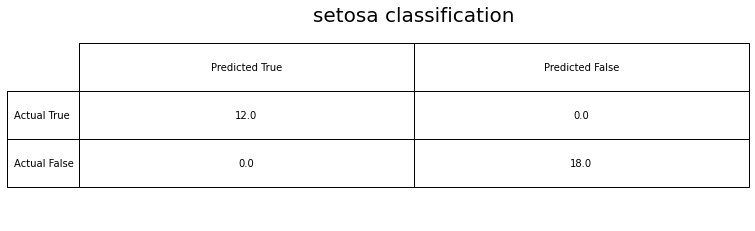

setosa classifier sensitivity is 1.0


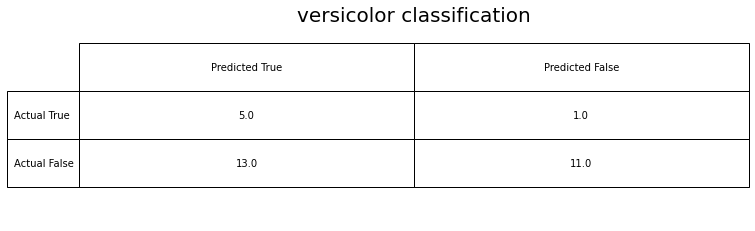

versicolor classifier sensitivity is 0.8333333333333334


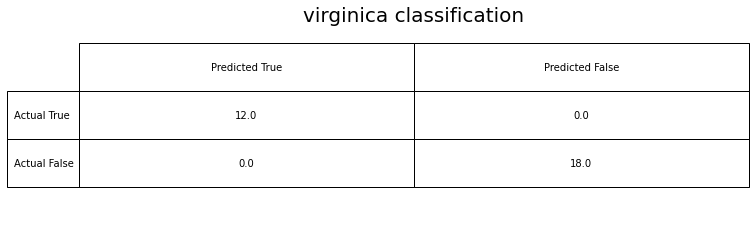

virginica classifier sensitivity is 1.0


In [194]:
for classifier in iris_model.classifiers:
    confusion_table = classifier.get_table_of_confustion(test_X, test_Y)
    class_name = iris['target_names'][classifier.unique_label]
    # Plotting the table
    table = plt.table(cellText=confusion_table, loc=(0,0), cellLoc='center', 
            rowLabels=["Actual True", "Actual False"], 
            colLabels=["Predicted True", "Predicted False"])
    table.scale(2, 4)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    plt.annotate(f"{class_name} classification", (.5,1), ha="center", va="top", fontsize=20)
    #plt.annotate('Predicted', (0,0.7), ha="left", va="center", fontsize=20, xycoords="figure fraction")
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    plt.show()

    # Print sensitivity
    sensitivity = classifier.get_sensitivity(test_X, test_Y)
    print(f"{class_name} classifier sensitivity is {sensitivity}")

The sensitivity of Setosa and virginica classifiers is excelent.
The sensitivity of Versicolor classifier is not perfect,
and it's selectivity is very poor.

# (e)
**RBF Kernel**

In [195]:
GAMMA = 0.5
# Todo optimize
def RBF(X, X_in):
    if X.ndim > 1 and X_in.ndim > 1:
        return np.exp(-GAMMA * np.linalg.norm(X-np.stack([X_in.T]*len(X), axis=1), axis=2)**2).T
        # X_in = X_in.T
        # result = np.zeros((len(X), len(X_in)))
        # for i in range(len(X_in)):
        #     for j in range(len(X)):
        #         diff = (X[j] - X_in[i])
        #         result[j][i] = np.exp(-GAMMA * diff.dot(diff))
        # return result
    else:
        return np.exp(-GAMMA * np.linalg.norm((X - X_in.T), axis=X.ndim-1)**2)

# optimize_c(kernel=RBF)

classes = np.unique(iris["target"])

# for C in [100, 10, 5, 2, 1, 0.9, 0.8, 0.5, 0.2, 0.1]:
C=1
print(f"C={C}")
iris_model = MulticlassSVM(class_labels=classes, c=C, kernel=RBF)
iris_model.fit(train_X, train_Y)
for classifier in iris_model.classifiers:
    class_name = iris['target_names'][classifier.unique_label]
    err = classifier.evaluate_model(validation_X, validation_Y)
    print(f"{class_name} classification error: {err}")

C=1
setosa classification error: 0.0
versicolor classification error: 0.0
virginica classification error: 0.0


In [196]:
# from sklearn import svm

# def get_binary_labels(labels, unique):
#         """Generate new labels vector, by replacing the unique label with 1,
#         and other labels with -1.
#         """
#         return [1 if label == unique else -1 
#                 for label in labels]

# def train_and_evaluate_model(model, label, name, train_x, train_y, test_x, test_y):
#     model.fit(train_x, get_binary_labels(train_y, unique=label))
#     predicted_labels = model.predict(test_x)
#     # count misclassified labels
#     labels = get_binary_labels(test_y, unique=label)
#     error_count = sum(abs(predicted_labels - labels) / 2)
#     error_ratio = error_count / len(labels)
#     print(f"{name} aclassification error: {error_ratio}")

# for C in [10, 5, 1, 0.9, 0.8, 0.5, 0.2, 0.1]:
#     print(f"C={C}")

#     setosa_classifier = svm.SVC(C=C, kernel='linear')
#     versic_classifier = svm.SVC(C=C, kernel='linear')
#     virginica_classifier = svm.SVC(C=C, kernel='linear')


#     train_and_evaluate_model(virginica_classifier, 2, "Virginica", train_X, train_Y, 
#                             validation_X, validation_Y)
#     train_and_evaluate_model(setosa_classifier, 0, "Setosa", train_X, train_Y, 
#                             validation_X, validation_Y)
#     train_and_evaluate_model(versic_classifier, 1, "Versic", train_X, train_Y, 
#                             validation_X, validation_Y)